# Decision Trees (DT)

Decision trees are versatile machine learning algorithms that can perform both
 classification and regression tasks, and even multioutput tasks. 

 They are powerful
 algorithms, capable of fitting complex datasets. Decision trees are also the fundamental components of random forests,
 which are among the most powerful machine learning algorithms available today.

 In this chapter we will start by discussing how to train, visualize, and make predictions
 with decision trees. Then we will go through the CART training algorithm used by
 Scikit-Learn, and we will explore how to regularize trees and use them for regression
 tasks. Finally, we will discuss some of the limitations of decision trees.

##  Training and Visualizing a Decision Tree

 To understand decision trees, let’s build one and take a look at how it makes
 predictions. The following code trains a DecisionTreeClassifier on the iris
 dataset

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [2]:
iris = load_iris(as_frame=True)
x_iris = iris.data[['petal length (cm)', 'petal width (cm)']].values
y_iris = iris.target

In [3]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=50)
tree_clf.fit(x_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=50)

 You can visualize the trained decision tree by first using the export_graphviz()
 function to output a graph definition file called iris_tree.dot

In [4]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, 
                out_file='iris_tree.dot', 
                feature_names=['petal length (cm)', 'petal width (cm)'], 
                class_names=iris.target_names, 
                rounded=True, 
                filled=True
                )

 Then you can use graphviz.Source.from_file() to load and display the file
 in a Jupyter notebook

In [5]:
from graphviz import Source
scr = Source.from_file("iris_tree.dot")
scr.view()

'iris_tree.dot.pdf'

## Making Predictions

From the "iris_tree.dot" predictions,  Suppose you find
 an iris flower and you want to classify it based on its petals. You start at the root node
(depth 0, at the top): this node asks whether the flower’s petal length is smaller than
 2.45 cm. If it is, then you move down to the root’s left child node (depth 1, left). In this
 case, it is a leaf node (i.e., it does not have any child nodes), so it does not ask any
 questions: simply look at the predicted class for that node, and the decision tree
 predicts that your flower is an Iris setosa (class=setosa).
 Now suppose you find another flower, and this time the petal length is greater than
 2.45 cm. You again start at the root but now move down to its right child node (depth
 1, right). This is not a leaf node, it’s a split node, so it asks another question: is the
 petal width smaller than 1.75 cm? If it is, then your flower is most likely an Iris
 versicolor (depth 2, left). If not, it is likely an Iris virginica (depth 2, right). It’s really
 that simple.

#### NOTE:
 One of the many qualities of decision trees is that they require very little data preparation. In fact, they
 don’t require feature scaling or centering at all.

A node’s samples attribute counts how many training instances it applies to. For
 example, 100 training instances have a petal length greater than 2.45 cm (depth 1,
 right), and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left). A
 node’s value attribute tells you how many training instances of each class this node
 applies to: for example, the bottom-right node applies to 0 Iris setosa, 1 Iris versicolor,
 and 45 Iris virginica. Finally, a node’s gini attribute measures its Gini impurity: a
 node is “pure” (gini=0) if all training instances it applies to belong to the same class.
 For example, since the depth-1 left node applies only to Iris setosa training instances, it
 is pure and its Gini impurity is 0. Equation 6-1 shows how the training algorithm
 computes the Gini impurity G of the i node. The depth-2 left node has a Gini
 impurity equal to 1 – (0/54)^2 – (49/54)^2 – (5/54)^2 ≈ 0.168.

###### Equation For Gini Impurity:

 Gi =1−∑(k=1, n)[Pi,k^2]

###### In This Equation:

Gi is the Gini impurity of the ith node.
Pi,k is the ratio of class instances among the training instances in the ith node.

#### NOTE:
 Scikit-Learn uses the CART algorithm, which produces only binary trees, meaning trees where split
 nodes always have exactly two children (i.e., questions only have yes/no answers). However, other
 algorithms, such as ID3, can produce decision trees with nodes that have more than two children.

#### TIP:
 The tree structure, including all the information shown in iris_tree.dot is available via the classifier's "tree_" attribute. Type "help(tree_clf.tree_)" for details.

In [6]:
help(tree_clf.tree_)

Help on Tree object:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leaves, childre

#### MODEL INTERPRETATION: WHITE BOX VERSUS BLACK BOX
Decision trees are intuitive, and their decisions are easy to interpret. Such models
 are often called white box models. In contrast, as you will see, random forests and
 neural networks are generally considered black box models. They make great
 predictions, and you can easily check the calculations that they performed to make
 these predictions; nevertheless, it is usually hard to explain in simple terms why
 the predictions were made. For example, if a neural network says that a particular
 person appears in a picture, it is hard to know what contributed to this prediction:
 Did the model recognize that person’s eyes? Their mouth? Their nose? Their
 shoes? Or even the couch that they were sitting on? Conversely, decision trees
 provide nice, simple classification rules that can even be applied manually if need
 be (e.g., for flower classification). The field of interpretable ML aims at creating
 ML systems that can explain their decisions in a way humans can understand. This
 is important in many domains—for example, to ensure the system does not make
 unfair decisions.

## Estimating Class Probabilities

 A decision tree can also estimate the probability that an instance belongs to a particular
 class k. . First it traverses the tree to find the leaf node for this instance, and then it
 returns the ratio of training instances of class k in this node. For example, suppose you
 have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding
 leaf node is the depth-2 left node, so the decision tree outputs the following
 probabilities: 0% for Iris setosa (0/54), 90.7% for Iris versicolor (49/54), and 9.3% for
 Iris virginica (5/54). And if you ask it to predict the class, it outputs Iris versicolor
 (class 1) because it has the highest probability. Let’s check this:

In [7]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [8]:
tree_clf.predict([[5, 1.5]])

array([1])

## The CART Training Algorithm
Scikit-Learn uses the Classification and Regression Tree (CART) algorithm to train
 decision trees (also called “growing” trees). The algorithm works by first splitting the
 training set into two subsets using a single feature k and a threshold t (e.g., “petal
 length ≤ 2.45 cm”). How does it choose k and t ?


 It searches for the pair (k, t ) that
 produces the purest subsets, weighted by their size. Equation below gives the cost
 function that the algorithm tries to minimize.

###### CART cost function for classification.



Once the CART algorithm has successfully split the training set in two, it splits the
subsets using the same logic, then the sub-subsets, and so on, recursively. It stops
recursing once it reaches the maximum depth (defined by the max_depth
hyperparameter), or if it cannot find a split that will reduce impurity.

A few otherhyperparameters (described in a moment) control additional stopping conditions:
- "min_samples_split", 
- "min_samples_leaf", 
- "min_weight_fraction_leaf", and
- "max_leaf_nodes"

#### WARNING:

 As you can see, the CART algorithm is a greedy algorithm: it greedily searches for an optimum split at
 the top level, then repeats the process at each subsequent level. It does not check whether or not the
 split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a
 solution that’s reasonably good but not guaranteed to be optimal.

## Computational Complexity

 Making predictions requires traversing the decision tree from the root to a leaf.
 Decision trees generally are approximately balanced, so traversing the decision tree
 requires going through roughly O(log (m)) nodes, where log (m) is the binary
 logarithm of m, equal to log(m) / log(2). Since each node only requires checking the
 2
 2
2
 value of one feature, the overall prediction complexity is O(log (m)), independent of
 the number of features. So predictions are very fast, even when dealing with large
 training sets.
 The training algorithm compares all features (or less if max_features is set) on all
 samples at each node. Comparing all features on all samples at each node results in a
 training complexity of O(n × m log (m)).

## Gini Impurity or Entropy
 By default, the DecisionTreeClassifier class uses the Gini impurity measure,
 but you can select the entropy impurity measure instead by setting the criterion
 hyperparameter to "entropy".

## Regularization Hyperparameters.


Decision trees make very few assumptions about the training data (as opposed to linear
 models, which assume that the data is linear, for example). If left unconstrained, the
 tree structure will adapt itself to the training data, fitting it very closely—indeed, most
 likely overfitting it. Such a model is often called a nonparametric model, not because it
does not have any parameters (it often has a lot) but because the number of parameters
 is not determined prior to training, so the model structure is free to stick closely to the
 data. In contrast, a parametric model, such as a linear model, has a predetermined
 number of parameters, so its degree of freedom is limited, reducing the risk of
 overfitting (but increasing the risk of underfitting).

 To avoid overfitting the training data, you need to restrict the decision tree’s freedom
 during training. As you know by now, this is called regularization. The regularization
 hyperparameters depend on the algorithm used, but generally you can at least restrict
 the maximum depth of the decision tree. In Scikit-Learn, this is controlled by the
 "max_depth" hyperparameter. The default value is "None", which means unlimited.
 Reducing "max_depth" will regularize the model and thus reduce the risk of
 overfitting.

The DecisionTreeClassifier class has a few other parameters that similarly restrict the shape of the decision tree:
  - max_features -   Maximum number of features that are evaluated for splitting at each node.
  - max_leaf_nodes - Maximum number of leaf nodes.
  - min_samples_split -  Minimum number of samples a node must have before it can be split
  - min_samples_leaf -  Minimum number of samples a leaf node must have to be created
  - min_weight_fraction_leaf - Same as min_samples_leaf but expressed as a fraction of the total number of weighted instances.
Increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model.


#### NOTE:
Other algorithms work by first training the decision tree without restrictions, then pruning (deleting)
 unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity
 improvement it provides is not statistically significant. Standard statistical tests, such as the χ test (chi
squared test), are used to estimate the probability that the improvement is purely the result of chance
 (which is called the null hypothesis). If this probability, called the p-value, is higher than a given
 threshold (typically 5%, controlled by a hyperparameter), then the node is considered unnecessary and
 its children are deleted. The pruning continues until all unnecessary nodes have been pruned.

 Let’s test regularization on the moons dataset, introduced in Chapter 5. We’ll train one
 decision tree without regularization, and another with min_samples_leaf=5.
 Here’s the code;

In [9]:
from sklearn.datasets import make_moons

x_moon, y_moon = make_moons(n_samples=150, noise=0.2, random_state=50)

tree_clf1 = DecisionTreeClassifier(random_state=50)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=50)

non_restricted = tree_clf1.fit(x_moon, y_moon)
restricted = tree_clf2.fit(x_moon, y_moon)

The unregularized model(tree_clf1) on the left is clearly overfitting, and the regularized model(tree_clf2) on
 the right will probably generalize better. We can verify this by evaluating both trees on
 a test set generated using a different random seed:

In [16]:
x_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=40)
score_1 = tree_clf1.score(x_moons_test, y_moons_test)
score_2 = tree_clf2.score(x_moons_test, y_moons_test)
print("Score for tree_clf1: ", score_1)
print("Score for tree_clf2: ", score_2)

Score for tree_clf1:  0.916
Score for tree_clf2:  0.902


## Regression

 Decision trees are also capable of performing regression tasks. Let’s build a regression
 tree using Scikit-Learn’s DecisionTreeRegressor class, training it on a noisy
 quadratic dataset with max_depth=2:

In [29]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(50)
x_quad = np.random.rand(200, 1) - 0.5 # A single random input feature.
y_quad = x_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=50)
tree_reg.fit(x_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=50)

In [30]:
export_graphviz(tree_reg, 
                out_file='quad_tree.dot', 
                #feature_names=x_quad, 
                class_names=y_quad, 
                rounded=True, 
                filled=True
                )

scr = Source.from_file("quad_tree.dot")
scr.view()

'quad_tree.dot.pdf'

Text(0.5, 0, 'x_quad')

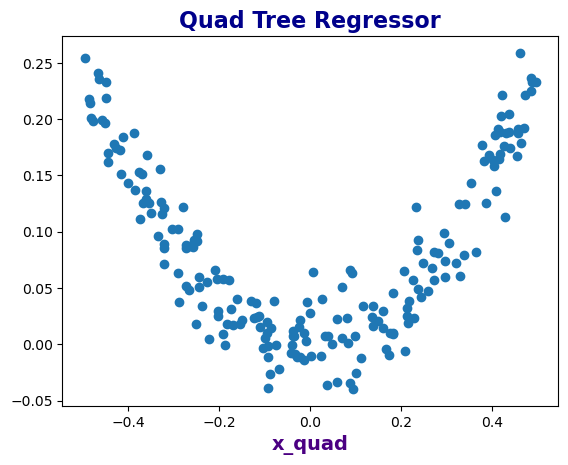

In [44]:
import matplotlib.pyplot as plt

plt.scatter(x_quad, y_quad)
plt.title("Quad Tree Regressor", fontsize=16, fontweight="bold", color="darkblue")
plt.xlabel("y_quad", fontsize=14, fontweight="bold", color="blue")
plt.xlabel("x_quad", fontsize=14, fontweight="bold", color="indigo")

 The CART algorithm works as described earlier, except that instead of trying to split
 the training set in a way that minimizes impurity, it now tries to split the training set in
 a way that minimizes the MSE.

 Just like for classification tasks, decision trees are prone to overfitting when dealing
 with regression tasks. Without any regularization (i.e., using the default
 hyperparameters), you get the predictions that are obviously overfitting the training set very badly. So, Optimal adjustments are very much needed for best performance model.

##  Sensitivity to Axis Orientation

 Hopefully by now you are convinced that decision trees have a lot going for them: they
 are relatively easy to understand and interpret, simple to use, versatile, and powerful.
 However, they do have a few limitations. First, as you may have noticed, decision trees
 love orthogonal decision boundaries (all splits are perpendicular to an axis), which
 makes them sensitive to the data’s orientation.

 But for now you
 only need to know that it rotates the data in a way that reduces the correlation between
 the features, which often (not always) makes things easier for trees.
Let’s create a small pipeline that scales the data and rotates it using PCA, then train a
 DecisionTreeClassifier on that data.

In [45]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
x_iris_rotated = pca_pipeline.fit_transform(x_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=50)
tree_clf_pca.fit(x_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=50)

## Decision Trees Have a High Variance

 More generally, the main issue with decision trees is that they have quite a high
 variance: small changes to the hyperparameters or to the data may produce very
 different models. In fact, since the training algorithm used by Scikit-Learn is stochastic
 —it randomly selects the set of features to evaluate at each node—even retraining the
 same decision tree on the exact same data may produce a very different model